# Task 2

In [1]:
# # > Uncomment and run this cell if running on Google Colab
# # install required dependencies for google colab
# !git clone https://github.com/benihime91/midas-summer-internship-2021.git
# !pip install --upgrade -r "/content/midas-summer-internship-2021/requirements.txt"

In [2]:
# # > for Goggle Colab
# import sys
# sys.path.append("midas-summer-internship-2021/")

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

## Part - 2
> Next, select only 0-9 training images from the above dataset, and use the pretrained network to train on MNIST dataset. Use the standard MNIST train and test splits (http://yann.lecun.com/exdb/mnist/). How does this pretrained network perform in comparison to a randomly initialized network in terms of convergence time, final accuracy and other possible training quality metrics? Do a thorough analysis. Please save your model checkpoints.

In [4]:
# import os
# os.makedirs("data", exist_ok=True)

# # Download the 1st Dataset using :
# !wget -P "data/" https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip
# !unzip --qq "data/trainPart1.zip" -d "data/"

In [21]:
# imports
import gc
import math
import os
import random
from collections import OrderedDict
from typing import *

import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
import pytorch_lightning.metrics.functional as FM
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from fastcore.all import *
from IPython.display import Markdown, display
from PIL import Image
from pytorch_lightning.callbacks import (BackboneFinetuning, BaseFinetuning,
                                         EarlyStopping, ModelCheckpoint)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch import nn, optim
from torchmetrics import Accuracy
from torchvision.datasets import MNIST

# custom imports
from model import xResModel
from progress import NotebookProgressCallback
from utils import DatasetFromPandas, ToFloat, folder2df, plot_images

pl.seed_everything(42)

pd.set_option("display.max_colwidth", None)

Global seed set to 42


### Get the Data ...
Let's create our Dataset and DataLoaders 

In [6]:
# we do need all the Images from the given dataset in the task
# we need only 0-9 images, and we will exclude the rest
exclude = "Sample0{}"
exclude = [exclude.format(o) for o in range(11, 63)]

DATASET_PATH = Path("data/train/")

# create the dataframe containing the dataset
df = folder2df(DATASET_PATH, exclude=exclude, shuffle=True)

# encode the labels in the dataframe
unq_cls = df.target.unique()
encoder = LabelEncoder()
encoder.fit(unq_cls)

def encode_label(x):
    "Encoder `x`, given x is a scalar value"
    return encoder.transform([x]).item()

df["cat_label"] = df["target"].map(encode_label)
df.head()

,image_id,target,cat_label
0,data/train/Sample008/img008-028.png,Sample008,7
1,data/train/Sample001/img001-049.png,Sample001,0
2,data/train/Sample002/img002-009.png,Sample002,1
3,data/train/Sample008/img008-014.png,Sample008,7
4,data/train/Sample004/img004-023.png,Sample004,3


In [9]:
# specify transformations
PRESIZE  = 80
IMG_SIZE = 64

transforms = T.Compose([
    T.Resize((PRESIZE, PRESIZE)),
    T.CenterCrop((IMG_SIZE, IMG_SIZE)),
    T.Grayscale(num_output_channels=3),
    T.ToTensor(),
    ToFloat(max_value=255.0),
])

In [11]:
ds = DatasetFromPandas(df, transforms)
dl = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=True,)

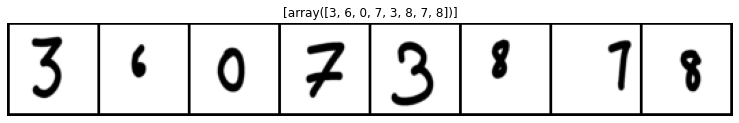

In [12]:
plot_images(dl)

Grab the MNIST dataset ...

In [15]:
# standard MNIST train dataset
mnist_train = MNIST(root="data/", train=True, download=True, transform=transforms)

# standard MNIST test dataset
mnist_test  = MNIST(root="data/", train=False, download=True, transform=transforms) 

# create dataloaders
mnist_train_dl = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
mnist_test_dl = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=False)

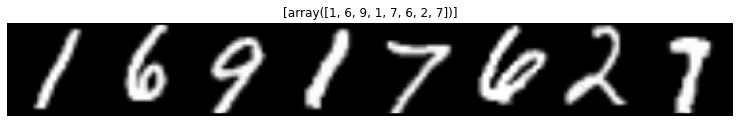

In [16]:
# view images from the training dataloader -
plot_images(mnist_train_dl)

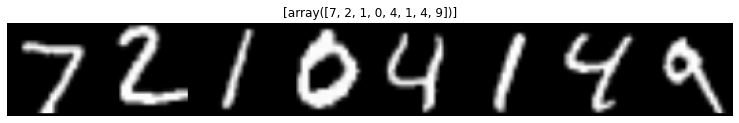

In [17]:
# view images from the training dataloader -
plot_images(mnist_test_dl)

### Create the PyTorch Lightning Task -

In [18]:
class ClassificationTask(pl.LightningModule):
    def __init__(self, model: nn.Module, lr: float, wd: float = 1e-02):
        super().__init__()
        self.save_hyperparameters("lr", "wd")
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
            
    def freeze_backbone(self):
        for param in model.backbone.parameters():
            param.requires_grad = False
        
    def forward(self, xb):
        "Same as nn.Module forward"
        return self.model(xb)

    def shared_step(self, batch, batch_idx, *args, **kwargs):
        """
        The common step shared between the training, validation & test steps
        """
        x, y = batch
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)
        acc  = FM.accuracy(F.softmax(y_hat), y)
        metrics = {'accuracy': acc, 'loss': loss}
        return metrics
    
    def training_step(self, batch, batch_idx, *args, **kwargs):
        metrics = self.shared_step(batch, batch_idx, *args, **kwargs)
        metrics = {'train_acc': metrics['accuracy'], 'train_loss': metrics['loss']}
        self.log_dict(metrics)
        return metrics["train_loss"]

    def validation_step(self, batch, batch_idx, *args, **kwargs):
        metrics = self.shared_step(batch, batch_idx, *args, **kwargs)
        metrics = {'val_acc': metrics['accuracy'], 'val_loss': metrics['loss']}
        self.log_dict(metrics)

    def test_step(self, batch, batch_idx, *args, **kwargs):
        metrics = self.shared_step(batch, batch_idx, *args, **kwargs)
        metrics = {'test_acc': metrics['accuracy'], 'test_loss': metrics['loss']}
        self.log_dict(metrics)
           
    def configure_optimizers(self):
        """
        define optimizers and LR schedulers for use in training.
        """
        # default Adam parameters from fast.ai
        parameters = list(self.parameters())
        trainable_parameters = list(filter(lambda p: p.requires_grad, parameters))
        opt = optim.AdamW(trainable_parameters, 
                          lr=self.hparams.lr, 
                          weight_decay=self.hparams.wd, 
                          betas=(0.9, 0.99), eps=1e-05)
        
        
        # Set up 1 cycle scheduler
        steps = len(self.train_dataloader())
        epochs= self.trainer.max_epochs
        
        scheduler= optim.lr_scheduler.OneCycleLR(
            opt, max_lr=self.hparams.lr, epochs=epochs, steps_per_epoch=steps)
        
        return [opt], [dict(scheduler=scheduler, interval='step')]

In [20]:
cbs = [NotebookProgressCallback()]

model = xResModel(num_outputs=10)
    
task = ClassificationTask(model, lr=3e-02)
task.unfreeze()
trainer = pl.Trainer(callbacks=cbs, max_epochs=10)
trainer.fit(task, train_dataloader=dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | xResModel        | 1.3 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.017     Total estimated model params size (MB)


epoch,train_acc,train_loss,time,samples/s
0,0.125000,2.135366,13.932000,0.933100
1,0.312500,1.796932,12.888900,1.008600
2,0.500000,1.193552,12.735100,1.020800
3,0.687500,0.795450,13.287400,0.978400
4,0.812500,0.343719,14.401500,0.902700
5,0.750000,0.684097,16.362900,0.794500
6,0.875000,0.345960,17.552800,0.740600
7,0.937500,0.202860,18.278100,0.711200
8,1.000000,0.070324,18.523900,0.701800
9,1.000000,0.095702,17.921100,0.725400


1

In [23]:
class FinetuningCallback(BaseFinetuning):
    def __init__(self, milestone: tuple = 5, train_bn: bool = False):
        self.milestones = milestone
        self.train_bn = train_bn

    def freeze_before_training(self, pl_module: pl.LightningModule):
        self.freeze(modules=pl_module.model.backbone, train_bn=self.train_bn)

    def finetune_function(self, pl_module: pl.LightningModule, epoch: int, optimizer, opt_idx: int):
        if epoch == self.milestones:
            self.unfreeze_and_add_param_group(
                modules=pl_module.model.backbone, 
                optimizer=optimizer, 
                train_bn=self.train_bn)

In [25]:
cbs = [NotebookProgressCallback(), FinetuningCallback(milestone=5),]

task = ClassificationTask(model, lr=3e-02)

trainer = pl.Trainer(callbacks=cbs, max_epochs=10, limit_train_batches=50, limit_val_batches=50)
trainer.fit(task, train_dataloader=mnist_train_dl, val_dataloaders=mnist_test_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | xResModel        | 1.3 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
2.6 K     Trainable params
1.3 M     Non-trainable params
1.3 M     Total params
5.017     Total estimated model params size (MB)


epoch,val_acc,val_loss,train_acc,train_loss,time,samples/s
0,0.333125,2.706406,0.265625,2.822630,31.513500,3.173200
1,0.381250,2.043952,0.296875,2.496827,31.464400,3.178200
2,0.440000,1.646513,0.421875,1.671243,30.799800,3.246800
3,0.511250,1.394503,0.453125,1.529520,30.339000,3.296100
4,0.557500,1.250649,0.484375,1.305031,30.662800,3.261300


KeyError: 'initial_lr'